-----------
### CNN for pretraining weight classification

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
# from torch.utils.tensorboard import SummaryWriter
# !pip install tensorboardX
# from tensorboardX import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
        [transforms.Resize((32, 32)),
         transforms.Grayscale(num_output_channels=3),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create datasets for training & validation, download if necessary
# handwritten
# training_set = torchvision.datasets.USPS('./data', train=True, transform=transform, download=True)
# validation_set = torchvision.datasets.USPS('./data', train=False, transform=transform, download=True)
# training_set = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
# validation_set = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)
# object recognition
training_set = torchvision.datasets.Caltech101('./data', transform=transform, download=True)
train_size = int(0.8 * len(training_set))
test_size = len(training_set) - train_size
training_set, validation_set = torch.utils.data.random_split(training_set, [train_size, test_size])


# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=16, shuffle=False)

# Class labels
# classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.usercontent.google.com/download?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=5ad55e6d-cfc4-453e-b16d-a24e220bc2e2
To: /content/data/caltech101/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:01<00:00, 114MB/s]


Extracting ./data/caltech101/101_ObjectCategories.tar.gz to ./data/caltech101


Downloading...
From (original): https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
From (redirected): https://drive.usercontent.google.com/download?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m&confirm=t&uuid=6bca7e97-43a0-4bf1-b6f1-518e1f6d74c7
To: /content/data/caltech101/Annotations.tar
100%|██████████| 14.0M/14.0M [00:00<00:00, 36.1MB/s]


Extracting ./data/caltech101/Annotations.tar to ./data/caltech101
Training set has 6941 instances
Validation set has 1736 instances


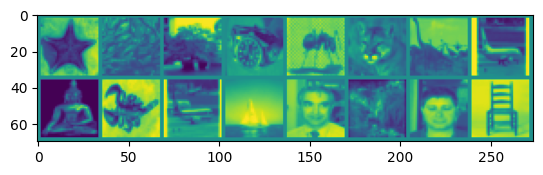

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
# print('  '.join(classes[labels[j]] for j in range(16)))

In [ ]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["validate_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["validate_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

#### Pre-training

In [ ]:
import os
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import time

#---Variable initialization---
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#-----------------------------

# PyTorch models inherit from torch.nn.Module
#---CNN---
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4):
        super(InceptionBlock, self).__init__()

        self.branch_A = nn.Sequential(
            nn.Conv2d(in_channels, c1, kernel_size=1),
            nn.ReLU()
        )

        self.branch_B = nn.Sequential(
            nn.Conv2d(in_channels, c2[0], kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.branch_C = nn.Sequential(
            nn.Conv2d(in_channels, c3[0], kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2),
            nn.ReLU()
        )

        self.branch_D = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, c4, kernel_size=1),
            nn.ReLU()
        )

    def forward(self, x):
        Block_A = self.branch_A(x)
        Block_B = self.branch_B(x)
        Block_C = self.branch_C(x)
        Block_D = self.branch_D(x)

        # Concatenation of all feature maps of x passing in each branch
        x_out = torch.cat([Block_A, Block_B, Block_C, Block_D], 1)
        return x_out

class handwrittenmodel(nn.Module):
    def __init__(self):
        super(handwrittenmodel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=4, stride=2, padding=1)  # 1x32x32 ---> 10x16x16
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 10x16x16 ---> 10x8x8
        self.inception = InceptionBlock(in_channels=10, c1=16, c2=[16, 32], c3=[8, 16], c4=16)
        self.fc1 = nn.Linear(80 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 101)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.inception(x)
        x = x.view(-1, 80 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Model init
model = handwrittenmodel().to(device)
summary(model, (3, 32, 32))

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Initializing in a separate cell so we can easily add more epochs to the same run
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 50
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

t_0_accelerated = time.time()
for epoch in range(EPOCHS):
    train_loss, train_correct = 0, 0
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+'best_pretrainedmodel.pth')

    epoch_number += 1

t_end_accelerated = time.time()-t_0_accelerated
print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end_accelerated} sec")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 16, 16]             490
         MaxPool2d-2             [-1, 10, 8, 8]               0
            Conv2d-3             [-1, 16, 8, 8]             176
              ReLU-4             [-1, 16, 8, 8]               0
            Conv2d-5             [-1, 16, 8, 8]             176
              ReLU-6             [-1, 16, 8, 8]               0
            Conv2d-7             [-1, 32, 8, 8]           4,640
              ReLU-8             [-1, 32, 8, 8]               0
            Conv2d-9              [-1, 8, 8, 8]              88
             ReLU-10              [-1, 8, 8, 8]               0
           Conv2d-11             [-1, 16, 8, 8]           3,216
             ReLU-12             [-1, 16, 8, 8]               0
        MaxPool2d-13             [-1, 10, 8, 8]               0
           Conv2d-14             [-1, 1

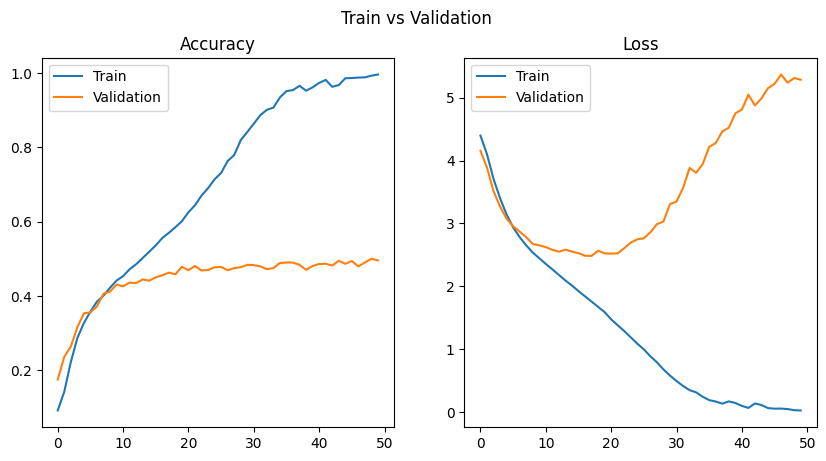

In [ ]:
plot_graph(training_logs)

In [ ]:
# Inference phase
PATH = './cp/best_pretrainedmodel.pth'
loaded_model = handwrittenmodel()
loaded_model.load_state_dict(torch.load(PATH))
acc_test = 0
test_loss = 0
loaded_model.to(device).eval()
for i, tdata in enumerate(validation_loader):
    tinputs, tlabels = tdata[0].to(device), tdata[1].to(device)
    toutputs = loaded_model(tinputs)
    loss = loss_fn(toutputs, tlabels)
    test_loss += loss

    _, preds_t = torch.max(toutputs, 1)
    acc_test += (preds_t == tlabels).float().mean().item()

accuracy_t = round(acc_test / float(len(validation_loader)), 4)
avg_tloss = test_loss / (i + 1)
print('[(pretraining || test loss: {}] [accuracy_test: {} %]'.format(avg_tloss, accuracy_t * 100))

<ipython-input-9-43f8c868aa6f>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(PATH))


[(pretraining || test loss: 2.4828407764434814] [accuracy_test: 46.27 %]


-------------
# Change classifier head to train another dataset

In [ ]:
transform = transforms.Compose(
        [transforms.Resize((32, 32)),
         transforms.Grayscale(num_output_channels=3),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
         ])

# Create datasets for training & validation, download if necessary
# handwritten
# training_set = torchvision.datasets.SVHN('./data', split='train', transform=transform, download=True)
# validation_set = torchvision.datasets.SVHN('./data', split='test', transform=transform, download=True)
# training_set = torchvision.datasets.QMNIST('./data', what='train', transform=transform, download=True)
# validation_set = torchvision.datasets.QMNIST('./data', what='test10k', transform=transform, download=True)
# object recognition
training_set = torchvision.datasets.STL10('./data', split='train', transform=transform, download=True)
validation_set = torchvision.datasets.STL10('./data', split='test', transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=16, shuffle=False)

# Class labels
# classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

100%|██████████| 2640397119/2640397119 [04:14<00:00, 10362515.50it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
Training set has 5000 instances
Validation set has 8000 instances


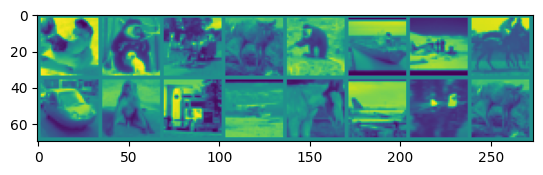

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
# print('  '.join(classes[labels[j]] for j in range(16)))

Change new head and some FC layers

In [ ]:
# Model init
new_model_head = handwrittenmodel().to(device)
#---load and replace new hidden layers---
checkpoint = torch.load('./cp/best_pretrainedmodel.pth')
# new_model_head.load_state_dict(checkpoint, strict=False) # open/close pre-trained weight
new_model_head.fc2 = nn.Linear(256, 64).to(device)  # change nn.Linear(x, x)
new_model_head.fc3 = nn.Linear(64, 10).to(device)   # change nn.Linear(x, x)
#---------------------------------------
summary(new_model_head, (3, 32, 32))

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(new_model_head.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epoch_number = 0

EPOCHS = 5
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 16, 16]             490
         MaxPool2d-2             [-1, 10, 8, 8]               0
            Conv2d-3             [-1, 16, 8, 8]             176
              ReLU-4             [-1, 16, 8, 8]               0
            Conv2d-5             [-1, 16, 8, 8]             176
              ReLU-6             [-1, 16, 8, 8]               0
            Conv2d-7             [-1, 32, 8, 8]           4,640
              ReLU-8             [-1, 32, 8, 8]               0
            Conv2d-9              [-1, 8, 8, 8]              88
             ReLU-10              [-1, 8, 8, 8]               0
           Conv2d-11             [-1, 16, 8, 8]           3,216
             ReLU-12             [-1, 16, 8, 8]               0
        MaxPool2d-13             [-1, 10, 8, 8]               0
           Conv2d-14             [-1, 1

<ipython-input-20-b55011bace11>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./cp/best_pretrainedmodel.pth')


In [ ]:
t_0_accelerated = time.time()
for epoch in range(EPOCHS):
    train_loss, train_correct = 0, 0
    # Make sure gradient tracking is on, and do a pass over the data
    new_model_head.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = new_model_head(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    new_model_head.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = new_model_head(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(new_model_head.state_dict(), path_save_cp+'best_resumemodel.pth')

    epoch_number += 1

t_end_accelerated = time.time()-t_0_accelerated
print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end_accelerated} sec")

Epochs 1   train loss 2.29888 train acc 0.10920 validate loss 2.28931 validate acc 0.16700
--------------------------------------------------------------------------------
Epochs 2   train loss 2.25912 train acc 0.20200 validate loss 2.19909 validate acc 0.17575
--------------------------------------------------------------------------------
Epochs 3   train loss 2.08749 train acc 0.22700 validate loss 2.02110 validate acc 0.25025
--------------------------------------------------------------------------------
Epochs 4   train loss 1.97936 train acc 0.26540 validate loss 1.95620 validate acc 0.26787
--------------------------------------------------------------------------------
Epochs 5   train loss 1.91824 train acc 0.29580 validate loss 1.94477 validate acc 0.27513
--------------------------------------------------------------------------------
Time consumption for accelerated CUDA training (device:cuda): 56.56043291091919 sec


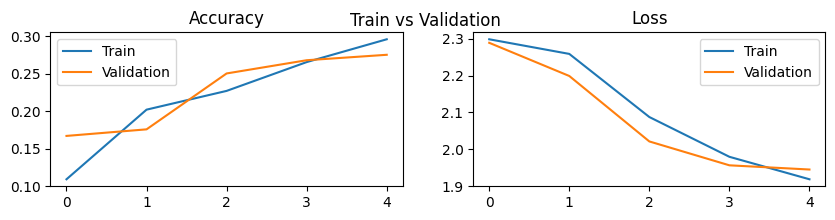

In [ ]:
plot_graph(training_logs)

In [ ]:
# Inference phase
PATH = './cp/best_resumemodel.pth'
loaded_resume_model = handwrittenmodel()
loaded_resume_model.fc2 = nn.Linear(256, 64).to(device)
loaded_resume_model.fc3 = nn.Linear(64, 10).to(device)
loaded_resume_model.load_state_dict(torch.load(PATH))
acc_test = 0
test_loss = 0
loaded_resume_model.to(device).eval()
stored_lbs = stored_preds = torch.empty(0, dtype=torch.float32)
for i, tdata in enumerate(validation_loader):
    tinputs, tlabels = tdata[0].to(device), tdata[1].to(device)
    toutputs = loaded_resume_model(tinputs)
    loss = loss_fn(toutputs, tlabels)
    test_loss += loss
    # Argmax one-hot pred to class vector
    _, preds_t = torch.max(toutputs, 1)
    acc_test += (preds_t == tlabels).float().mean().item()
    # store vec
    stored_lbs = stored_lbs.to(tlabels.device)
    stored_preds = stored_preds.to(preds_t.device)
    stored_lbs = torch.cat((stored_lbs, tlabels), 0)
    stored_preds = torch.cat((stored_preds, preds_t), 0)

accuracy_t = round(acc_test / float(len(validation_loader)), 4)
avg_tloss = test_loss / (i + 1)
print('[(resume training || test loss: {}] [accuracy_test: {} %]'.format(avg_tloss, accuracy_t * 100))

<ipython-input-23-9e9164e40c98>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_resume_model.load_state_dict(torch.load(PATH))


[(resume training || test loss: 1.9447674751281738] [accuracy_test: 27.51 %]


#### Additional Quantitative Matrics

In [ ]:
# @title ##### confusion matrix function
# https://github.com/fyse-nassar/Malware-Family-Classification/blob/master/Malware%20Opcode%20Ngrams%20Generator.ipynb
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    Normalization can be applied by setting `normalize=True`.
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)    #office-31
    plt.xticks(tick_marks, classes, rotation=20, fontsize=12)    #office-home
    plt.yticks(tick_marks, classes, fontsize=12)

    if normalize==True:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis]+1)
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    # print(cm)

    formated = '.2f' if normalize==True else 'd'
    #---manual---
    thresh = cm.max() / 2.
    #thresh > 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], formated),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #---sns---
    #df_cm = pd.DataFrame(cm, classes, classes)
    #sns.heatmap(df_cm, annot=True, fmt=formated, cmap=cmap)

    plt.gcf().set_size_inches(8, 6)
    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.margins(2,2)
    plt.tight_layout()

Precision/Recall/F-beta score: (0.2414497879382197, 0.275125, 0.21216493844936196, None)
NMI score: 0.13773172467232103, RI score: 0.08989162427947539


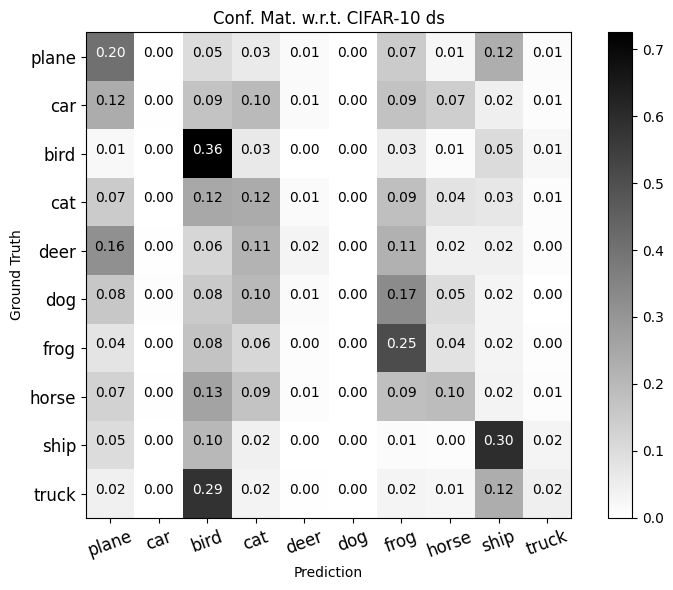

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, normalized_mutual_info_score, adjusted_rand_score#, f1_score
# Class labels
pos_labels = np.arange(10)
lb_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

lb = stored_lbs.cpu()
prd = stored_preds.cpu()
#---confusion matrix
cm_target = confusion_matrix(y_true=lb,
                            y_pred=prd,
                            labels=pos_labels,
                            normalize='true',
                            )
plt.figure()
plt.rcParams.update({'font.size': 10, 'figure.figsize': (2,2)})
plot_confusion_matrix(cm_target,
                        classes=lb_classes,
                        normalize=True,
                        title='Conf. Mat. w.r.t. CIFAR-10 ds',
                        cmap=plt.cm.binary #Blues_r
                        )    #Blues_r = off-white diagonal
#---F1-score/Precision/Recall scores
print("Precision/Recall/F-beta score:", precision_recall_fscore_support(lb, prd, average='weighted', zero_division=0,
                                          beta=1.0)) #labels=label_classes))
#---Normalized Mutual Information (NMI) score
nmi_score = normalized_mutual_info_score(labels_true=lb,
                                        labels_pred=prd,
                                        average_method='arithmetic',
                                        )
#---Rand Index (RI) score
ri_score = adjusted_rand_score(labels_true=lb,
                                labels_pred=prd,
                                )
print(f"NMI score: {nmi_score}, RI score: {ri_score}")

--------------------
# In-classes exercise

1. ทำไมความแม่นยำของ Model ที่ฝึกฝนบน SVHN dataset ใช้น้ำหนักจากการฝึกฝน (pretrained weight) บน MNIST dataset กลับมีความแม่นยำลดลง
2. เปรียบเทียบโมเดลที่ฝึกฝน SVHN ที่ใช้ pre-trained weight จาก MNIST กับโมเดลที่ฝึกฝกน SVHN แบบไม่ใช้น้ำหนักจาก pre-trained model โดยตั้งค่าจำนวนวนซ้ำแค่ 5 รอบ

\





--------------------
# Homework

เปลี่ยน pretraining model dataset เป็น Caltech101 (101 classes) จำนวนรอบการฝึกบน Caltech101 >= 10 รอบขึ้นไป

Ref: https://pytorch.org/vision/main/generated/torchvision.datasets.Caltech101.html

```
"""
  Arg: Class instruction
  torchvision.datasets.Caltech101(root: Union[str, Path], target_type: Union[List[str], str] = 'category', transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False)
"""
# Class use
split_ratio = 0.8 #<--- range of spliting dataset ratio {'training_size':0.8, 'testing_size':0.2}
ds = torchvision.datasets.Caltech101(root='./data',
                                     transform=transform,
                                     download=True)
train_size = int(split_ratio * len(ds))
test_size = len(ds) - train_size
training_set, testing_set = torch.utils.data.random_split(ds, [train_size, test_size])
```


และ resume training model dataset เป็น STL10 (10 classes) จำนวนรอบการฝึกบน STL10 <= 5 รอบ\
Ref: https://pytorch.org/vision/main/generated/torchvision.datasets.STL10.html


```
"""
  Arg: Class instruction
  torchvision.datasets.STL10(root: Union[str, Path], split: str = 'train', folds: Optional[int] = None, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False)
"""
# Class use
training_set = torchvision.datasets.STL10(root='./data/',
                                           transform=transforms,
                                           split='train',
                                           download=True)
testing_set = torchvision.datasets.STL10(root='./data/',
                                           transform=transforms,
                                           split='test',
                                           download=True)
```


1. ออกแบบโมเดลเดิมโดยใช้ Inception block ตามรูปข้างใต้ใช้กับ feature map ที่ออกจาก conv1 layer เพื่อรองรับ Caltech101 ที่มีวัตถุ 101 ประเภท และโมเดลสามารถเปลี่ยนหัวคัดแยก (Classifier head) เพื่อฝึกฝนต่อไปยัง STL10 ที่มี่วัตถุ 10 ประเภทได้
2. เปรียบเทียบโมเดลที่ฝึกฝน STL10 ที่ใช้ pre-trained weight จาก Caltech101 กับโมเดลที่ฝึกฝกน STL10 แบบไม่ใช้น้ำหนักจาก pre-trained model อภิปรายผลเปรียบเทียบเชิงทั้ง quantitative and visualization

\

#### Appendix

Inception block\
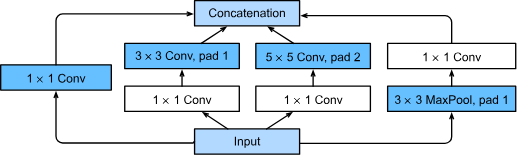

```
# ตัวอย่างการสร้าง inception block
class InceptionBlock(nn.Module):
    def __init__(self, in_channels):
        super(InceptionBlock, self).__init__()
        
        self.branch_A = nn.Sequential(
            ...
        )
        
        self.branch_B = nn.Sequential(
            ...
        )
        
        self.branch_C = nn.Sequential(
            ...
        )
        
        self.branch_D = nn.Sequential(
            ...
        )
        .
        .
        .
        self.branch_Z = nn.Sequential(
            ...
        )
    
    def forward(self, x):
        ... all forward passes of feature map (x) ...
        
        # Concatenation of all feature maps of x passing in each branch
        x_out = torch.cat([Block_A, Block_B, Block_C, Block_D, ..., branch_Z], 1)
        return x_out
```